# Gene Expression Analysis

In [1]:
# Loading the Packages

%reload_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

# from starmap.obj import STARMapDataset, load_data
# import starmap.analyze as anz
# import starmap.viz as viz
# import starmap.sc_util as su
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# test
# from starmap.utilities import *
# from starmap.sequencing import *
from anndata import AnnData

In [2]:
# Colormap related
import colorsys
from random import shuffle

def intervals(parts, start_point, end_point):
    duration = end_point - start_point
    part_duration = duration / parts
    return [((i * part_duration + (i + 1) * part_duration)/2) + start_point for i in range(parts)]

## Input

In [3]:
# Set path
base_path = '../'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(out_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

expr_path = os.path.join(out_path, 'expr_all.csv')

var_path = os.path.join(out_path, 'var.csv')
obs_path = os.path.join(out_path, 'obs_all.csv')

# add expression data to the AnnData object 
expr_x = np.loadtxt(expr_path, delimiter=',')

var = pd.read_csv(var_path, header=None)
var = pd.DataFrame(index=var.iloc[:,0].to_list())
obs = pd.read_csv(obs_path, index_col=0)

adata = AnnData(X=expr_x, var=var, obs=obs)

## Preprocessing

In [ ]:
# Plot top 20 most expressed genes 
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)

In [7]:
# Get a copy of meta data
meta = adata.obs.copy()

# Filtration 
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=20)

sc.pp.filter_cells(adata, min_counts=30)
sc.pp.filter_cells(adata, max_counts=1300)

adata.X.shape

(1099408, 1022)

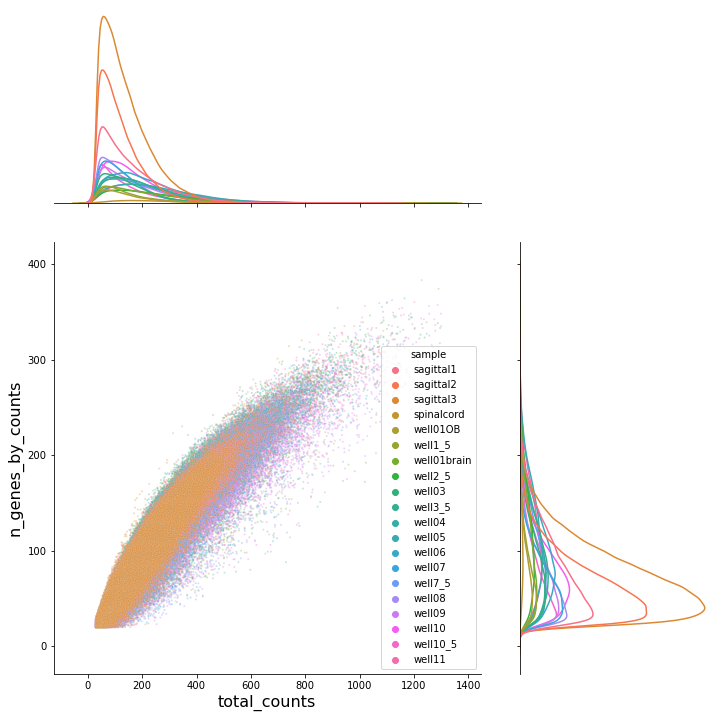

In [12]:
from scipy import stats
g = sns.JointGrid(data=adata.obs, x="total_counts", y="n_genes_by_counts",height=10,ratio=2,  hue="sample")
g.plot_joint(sns.scatterplot, s=4, alpha=.3)
g.plot_marginals(sns.kdeplot)
g.set_axis_labels('total_counts', 'n_genes_by_counts', fontsize=16)
# r, p = stats.pearsonr(adata.obs['total_counts'], adata.obs['n_genes_by_counts'])
# phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
# g.ax_joint.legend(['r={:f}, p={:f}'.format(r,p)])
plt.show()

In [13]:
# Normalization scaling
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
# Scale data to unit variance and zero mean
sc.pp.regress_out(adata, ['total_counts'])
sc.pp.scale(adata)

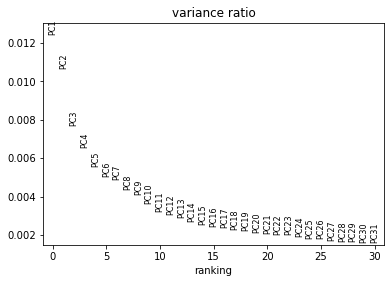

In [38]:
#compute pca
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=False)

In [39]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

# Run UMAP
sc.tl.umap(adata)

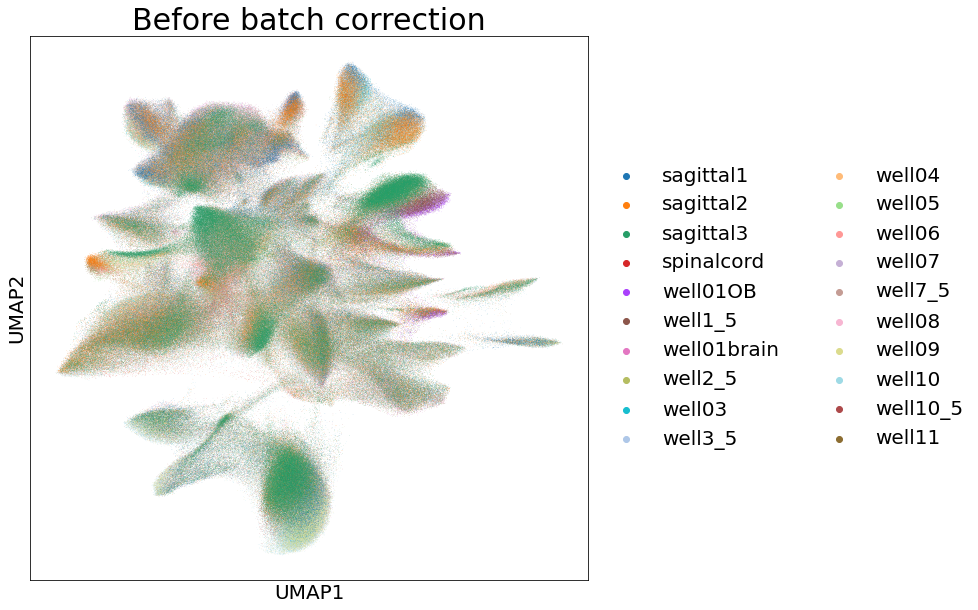

In [40]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(10,10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax=sc.pl.umap(adata,size=0.58, color='sample',legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Before batch correction')
ax.title.set_fontsize(30)

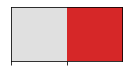

In [41]:
cluster_pl = sns.color_palette("tab20_r",2)#list(np.random.rand(14,3))#
cluster_pl[0]=np.array([0.88,0.88,0.88])
sns.palplot(cluster_pl)

In [42]:
adata.obs['sample'].unique()

['well01OB', 'well01brain', 'well08', 'well07', 'well03', ..., 'well04', 'well7_5', 'sagittal1', 'sagittal2', 'sagittal3']
Length: 20
Categories (20, object): ['well01OB', 'well01brain', 'well08', 'well07', ..., 'well7_5', 'sagittal1', 'sagittal2', 'sagittal3']

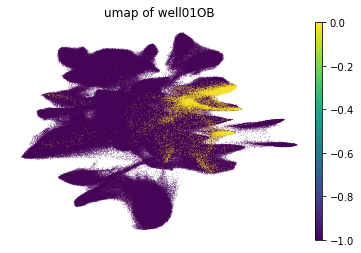

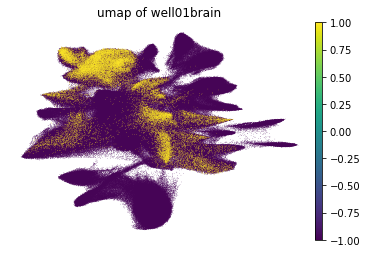

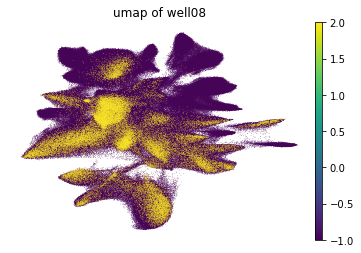

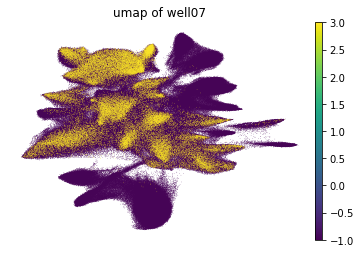

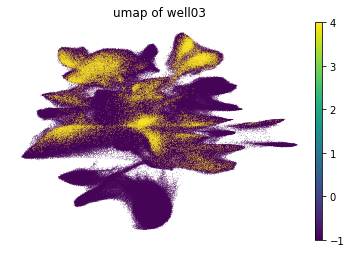

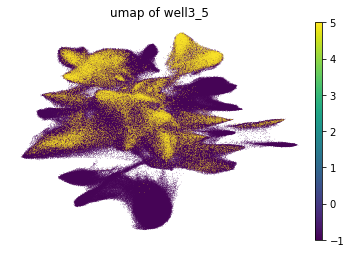

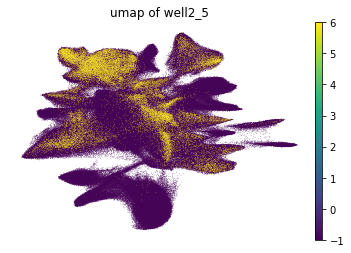

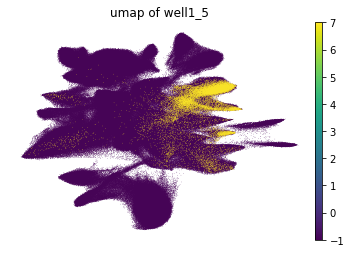

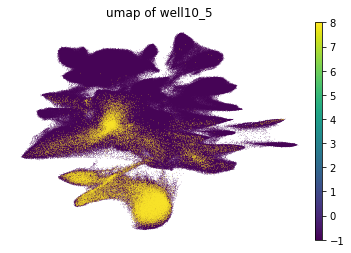

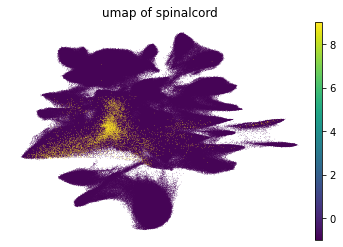

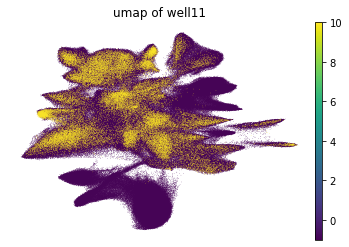

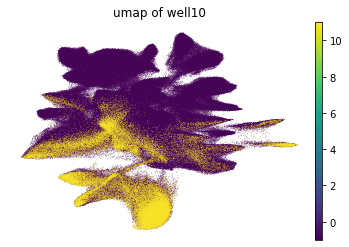

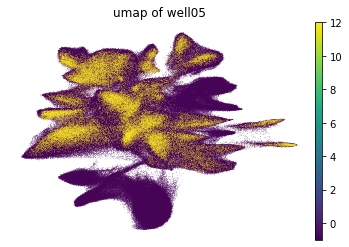

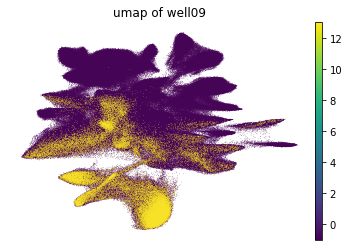

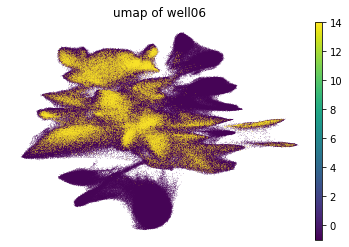

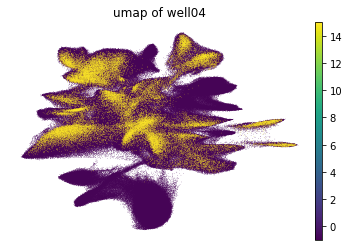

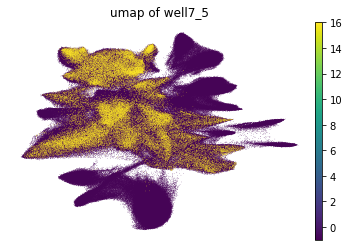

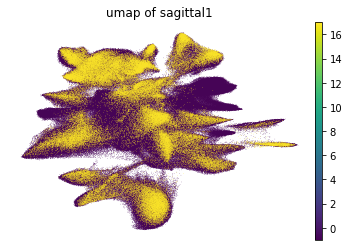

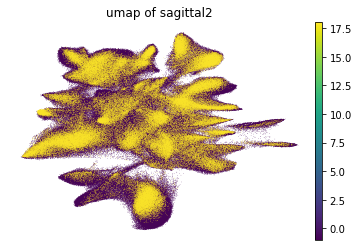

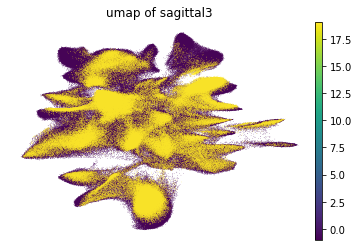

In [43]:
# adata.obs['test1']=adata.obs['test1'].astype('int')
for i,j in enumerate(adata.obs['sample'].unique()):

    adata.obs.loc[adata.obs['sample']==j,'test1']=i
    adata.obs.loc[adata.obs['sample']!=j,'test1']=-1

    adata.obs['test1']=adata.obs['test1'].astype('int')
#     adata.obs['test1']=adata.obs['test1'].astype('category')
    sc.pl.umap(adata, size=1,color='test1', legend_fontweight ='heavy',legend_fontsize=14,
                   legend_fontoutline=2, frameon=False, legend_loc='on data',
                   title=f'umap of {j}', palette=cluster_pl, save=False)
    adata.obs['test1']=adata.obs['test1'].astype('int')


In [44]:
adata.obs.loc[adata.obs['sample']=='well1_5','batch']='Well1.5_OB2'
adata.obs.loc[adata.obs['sample']=='well01OB','batch']='Well01_OB1'
adata.obs.loc[adata.obs['sample']=='well01brain','batch']='Well01_mPFC'
adata.obs.loc[adata.obs['sample']=='well08','batch']='Well08_Medulla'
adata.obs.loc[adata.obs['sample']=='well07','batch']='Well07_HPC'
adata.obs.loc[adata.obs['sample']=='well03','batch']='Well03_Forebrain'
adata.obs.loc[adata.obs['sample']=='well3_5','batch']='Well3.5_Striatum'
adata.obs.loc[adata.obs['sample']=='well2_5','batch']='Well2.5_mPFC'
adata.obs.loc[adata.obs['sample']=='well10_5','batch']='Well10.5_CB/Medulla'
adata.obs.loc[adata.obs['sample']=='spinalcord','batch']='SpinalCordL1'
adata.obs.loc[adata.obs['sample']=='well11','batch']='Well11_HPC'
adata.obs.loc[adata.obs['sample']=='well10','batch']='Well10_CB'
adata.obs.loc[adata.obs['sample']=='well05','batch']='Well05_HPC'
adata.obs.loc[adata.obs['sample']=='well09','batch']='Well09_CB'
adata.obs.loc[adata.obs['sample']=='well06','batch']='Well06_HPC'
adata.obs.loc[adata.obs['sample']=='well04','batch']='Well04_Striatum'

In [54]:
# new = sc.pp.subsample(adata_combat, fraction=1., copy=True)


In [55]:
# # adata_combat.obs['test1']=adata_combat.obs['test1'].astype('int')
# for i,j in enumerate(adata_combat.obs['sample'].unique()):
# #     if i==5:
#     adata_combat.obs.loc[adata_combat.obs['sample']==j,'test1']=i
#     adata_combat.obs.loc[adata_combat.obs['sample']!=j,'test1']=-1

#     adata_combat.obs['test1']=adata_combat.obs['test1'].astype('int')
# #         adata_combat.obs['test1']=adata_combat.obs['test1'].astype('category')
#     sc.pl.umap(adata_combat, size=1,color='test1', groups=i,legend_fontweight ='heavy',legend_fontsize=14,
#                    legend_fontoutline=2, frameon=False, legend_loc='on data',
#                    title=f'umap of {j}', palette=cluster_pl, save=False)
# #         adata_combat.obs['test1']=adata_combat.obs['test1'].astype('int')


# batch effect

In [56]:
batch1='well04'
batch2='well3_5'
batch3='well2_5'
batch4='well03'

In [57]:
adata_obsub=adata[[a or b or c or d  for a, b, c, d in zip(list(adata.obs['sample']==batch1),list(adata.obs['sample']==batch2), list(adata.obs['sample']==batch3), list(adata.obs['sample']==batch4) )] ,:].copy()

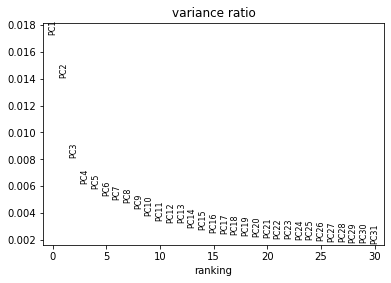

In [58]:
#compute pca
sc.tl.pca(adata_obsub, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_obsub, log=False)

In [59]:
sc.pp.neighbors(adata_obsub, n_neighbors=10, n_pcs=30)

# Run UMAP
sc.tl.umap(adata_obsub)

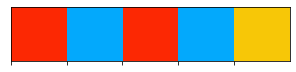

In [60]:
cluster_pl = sns.color_palette("tab20_r",5)
cluster_pl[0]=np.array([252,40,3])/255
cluster_pl[1]=np.array([3, 169, 252])/255
cluster_pl[2]=np.array([252,40,3])/255
cluster_pl[3]=np.array([3, 169, 252])/255
cluster_pl[4]=np.array([247, 199, 7])/255
# cluster_pl=list(np.random.rand(4,3))
sns.palplot(cluster_pl)

... storing 'batch' as categorical


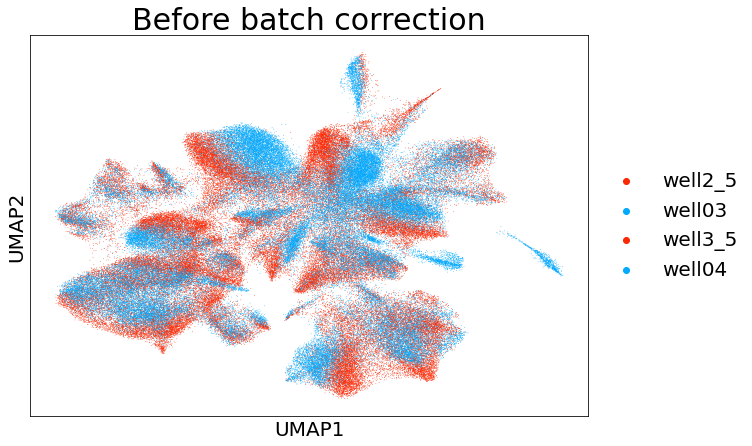

In [61]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(10,7))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax=sc.pl.umap(adata_obsub,size=2, color='sample',palette=cluster_pl,legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Before batch correction')
ax.title.set_fontsize(30)

In [62]:
#batch correction
adata_combat = adata_obsub.copy()
sc.pp.combat(adata_combat, key='sample')

In [63]:
#plot umap after batch correction
sc.pp.pca(adata_combat,  svd_solver='arpack')

sc.pp.neighbors(adata_combat, n_neighbors=10, n_pcs=30)

sc.tl.umap(adata_combat)

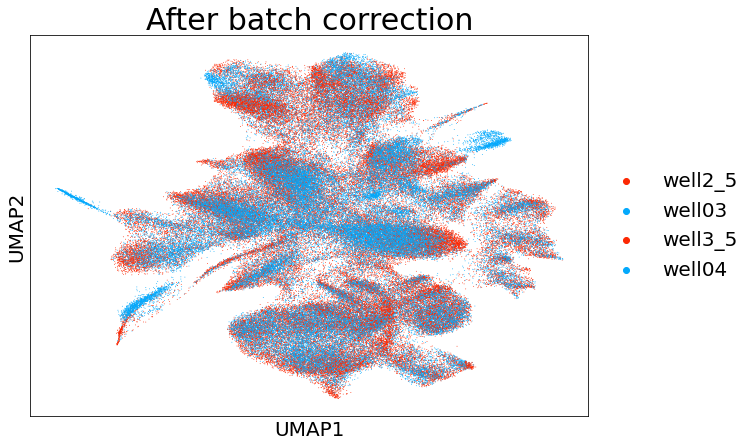

In [64]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(10,7))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax=sc.pl.umap(adata_combat,size=3, color='sample',palette=cluster_pl,legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('After batch correction')
ax.title.set_fontsize(30)

In [66]:
p=[a or b or c or d  for a, b, c, d in zip(list(adata.obs['sample']==batch1),list(adata.obs['sample']==batch2), list(adata.obs['sample']==batch3), list(adata.obs['sample']==batch4) )] 
adata_obsub=adata[p ,:].copy()
adata.X[p,:]=adata_combat.X

add well 05

In [72]:
adata2=adata[adata.obs['sample']=='well05',:].copy()
# adata_obsub=adata[[a or b or c or d for a, b, c, d in zip(list(adata.obs['sample']==batch1),list(adata.obs['sample']==batch2), list(adata.obs['sample']==batch3), list(adata.obs['sample']==batch4) )] ,:].copy()
adata_combat_05=adata_obsub.concatenate(adata2)

In [74]:
#plot umap after batch correction
sc.pp.pca(adata_combat_05,  svd_solver='arpack')

sc.pp.neighbors(adata_combat_05,n_neighbors=10,n_pcs=30)

sc.tl.umap(adata_combat_05)

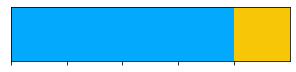

In [75]:
cluster_pl = sns.color_palette("tab20_r",5)
cluster_pl[0]=np.array([3, 169, 252])/255
cluster_pl[1]=np.array([3, 169, 252])/255
cluster_pl[2]=np.array([3, 169, 252])/255
cluster_pl[3]=np.array([3, 169, 252])/255
cluster_pl[4]=np.array([247, 199, 7])/255
# cluster_pl=list(np.random.rand(4,3))
sns.palplot(cluster_pl)

... storing 'sample' as categorical


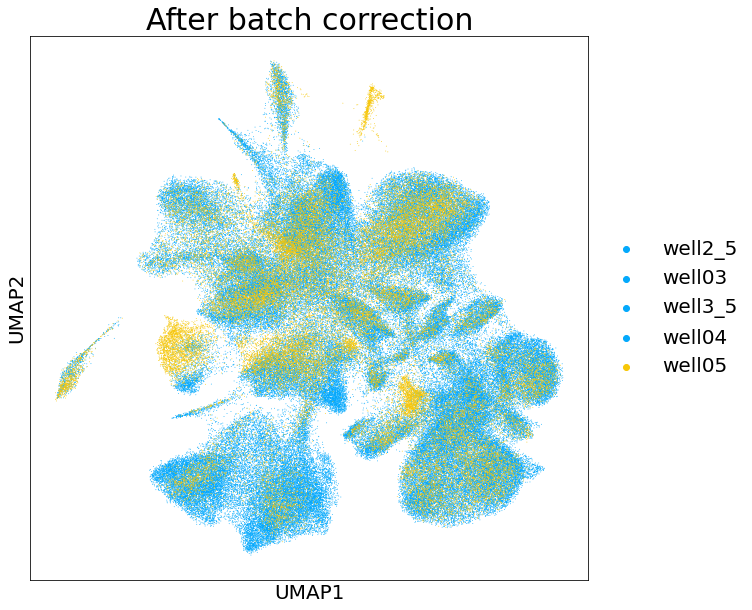

In [76]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(10,10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax=sc.pl.umap(adata_combat_05,size=3, color='sample',palette=cluster_pl,legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('After batch correction')
ax.title.set_fontsize(30)

sagittal vs coronal

In [92]:
adatacopy=adata.copy()

In [93]:
adatacopy.obs['batch_s_c']='coronal'
adatacopy.obs.loc[adatacopy.obs['sample']=='sagittal3','batch_s_c']='sagittal'
adatacopy.obs.loc[adatacopy.obs['sample']=='sagittal2','batch_s_c']='sagittal'
adatacopy.obs.loc[adatacopy.obs['sample']=='sagittal1','batch_s_c']='sagittal'

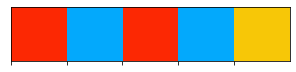

In [94]:
cluster_pl = sns.color_palette("tab20_r",5)
cluster_pl[0]=np.array([252,40,3])/255
cluster_pl[1]=np.array([3, 169, 252])/255
cluster_pl[2]=np.array([252,40,3])/255
cluster_pl[3]=np.array([3, 169, 252])/255
cluster_pl[4]=np.array([247, 199, 7])/255
# cluster_pl=list(np.random.rand(4,3))
sns.palplot(cluster_pl)

... storing 'batch' as categorical
... storing 'batch_s_c' as categorical


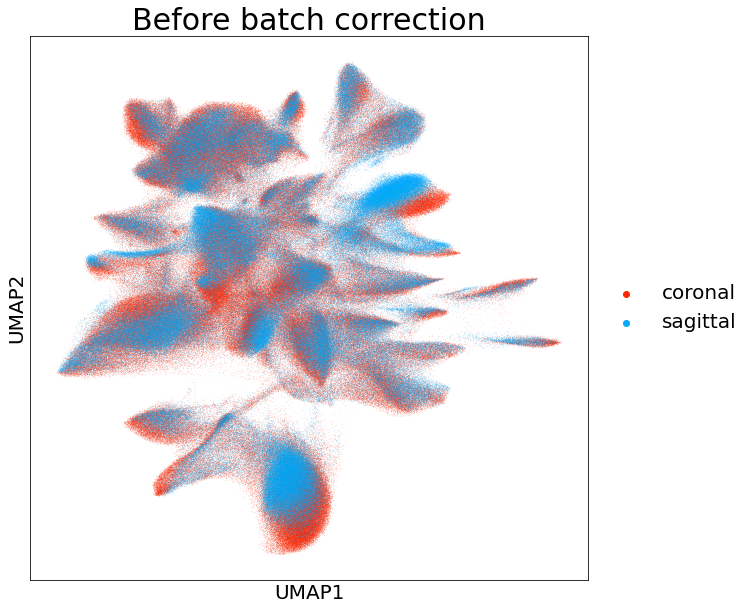

In [95]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(10,10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax=sc.pl.umap(adatacopy,size=0.58, color='batch_s_c',palette=cluster_pl,legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Before batch correction')
ax.title.set_fontsize(30)

In [96]:
#batch correction
sc.pp.combat(adatacopy, key='batch_s_c')

In [97]:
#plot umap after batch correction
sc.pp.pca(adatacopy,  svd_solver='arpack')

sc.pp.neighbors(adatacopy, n_neighbors=10, n_pcs=30)

sc.tl.umap(adatacopy)

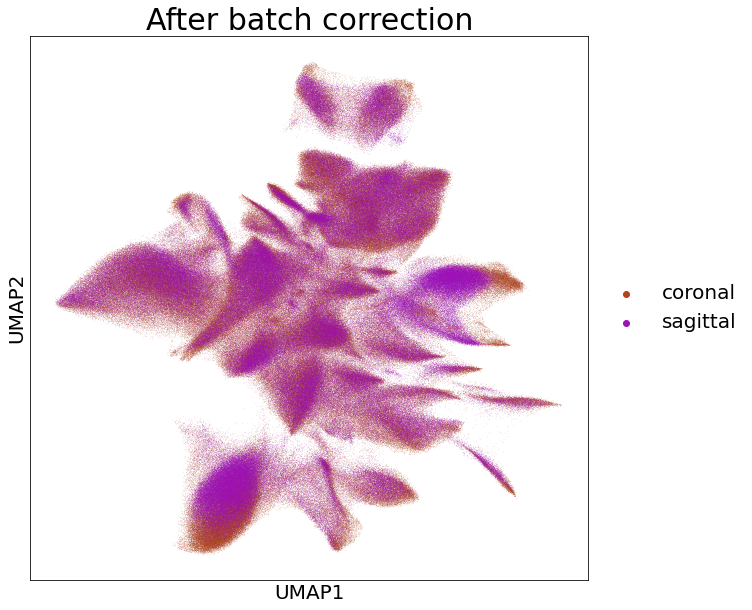

In [126]:
cluster_pl=list(np.random.rand(20,3))
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(10,10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax=sc.pl.umap(adatacopy,size=0.58, color='batch_s_c',palette=cluster_pl,legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('After batch correction')
ax.title.set_fontsize(30)

In [99]:
adata=adatacopy

end of batch effect correction

# integration with scRNA-seq

In [6]:
adata_sc=sc.read_h5ad('../scrna.h5ad')
adata_sc.var.index=adata_sc.var.index.str.upper()
adata_sc.var_names_make_unique()


adata.var.index=adata.var.index.str.upper()
list_of_variable_names=adata.var.index.intersection(adata_sc.var.index)
adata_subset = adata[:, list_of_variable_names]

list_of_variable_names=adata_sc.var.index.intersection(adata.var.index)
adata_sc_subset = adata_sc[:, list_of_variable_names]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
# Normalization scaling sc
sc.pp.normalize_total(adata_sc_subset)
sc.pp.log1p(adata_sc_subset)

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata_sc_subset, percent_top=None, inplace=True)

# Scale data to unit variance and zero mean
sc.pp.regress_out(adata_sc_subset, ['total_counts'])
sc.pp.scale(adata_sc_subset)

In [13]:
subset=adata_sc_subset.obs.drop(adata_sc_subset[adata_sc_subset.obs['TaxonomyRank2']=='PNS neurons'].obs.index)
adata_sc_subset=adata_sc_subset[subset.index,:]

subset=adata_sc_subset.obs.drop(adata_sc_subset[adata_sc_subset.obs['Description']=='Enteric glia'].obs.index)
adata_sc_subset=adata_sc_subset[subset.index,:]

subset=adata_sc_subset.obs.drop(adata_sc_subset[adata_sc_subset.obs['Description']=='Satellite glia'].obs.index)
adata_sc_subset=adata_sc_subset[subset.index,:]

subset=adata_sc_subset.obs.drop(adata_sc_subset[adata_sc_subset.obs['Description']=='Schwann cells'].obs.index)
adata_sc_subset=adata_sc_subset[subset.index,:]

In [33]:
combine_adata=adata_subset.concatenate(adata_sc_subset,batch_key='dataset', batch_categories=['st','scrna'])

In [34]:
sc.tl.pca(combine_adata,n_comps=100)

In [35]:
import scanpy.external as sce
sce.pp.harmony_integrate(combine_adata, 'dataset')

2021-10-24 11:00:54,413 - harmonypy - INFO - Iteration 1 of 10
2021-10-24 11:16:49,983 - harmonypy - INFO - Iteration 2 of 10
2021-10-24 11:32:40,009 - harmonypy - INFO - Iteration 3 of 10
2021-10-24 11:41:25,057 - harmonypy - INFO - Iteration 4 of 10
2021-10-24 11:46:56,713 - harmonypy - INFO - Iteration 5 of 10
2021-10-24 11:52:27,658 - harmonypy - INFO - Iteration 6 of 10
2021-10-24 11:58:00,749 - harmonypy - INFO - Iteration 7 of 10
2021-10-24 12:03:33,189 - harmonypy - INFO - Iteration 8 of 10
2021-10-24 12:09:01,018 - harmonypy - INFO - Iteration 9 of 10
2021-10-24 12:14:26,623 - harmonypy - INFO - Converged after 9 iterations


In [36]:
sc.pp.neighbors(combine_adata,n_neighbors=50,use_rep='X_pca_harmony')

In [37]:
sc.tl.umap(combine_adata)

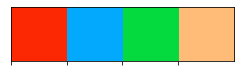

In [38]:
cluster_pl = sns.color_palette("tab20",4)
cluster_pl[0]=np.array([252,40,3])/255
cluster_pl[1]=np.array([3, 169, 252])/255
cluster_pl[2]=np.array([4,217,61])/255
# cluster_pl=list(np.random.rand(4,3))
sns.palplot(cluster_pl)

... storing 'sample' as categorical
... storing 'batch' as categorical
... storing 'batch_s_c' as categorical
... storing 'CellID' as categorical
... storing 'Age' as categorical
... storing 'AnalysisPool' as categorical
... storing 'AnalysisProject' as categorical
... storing 'Bucket' as categorical
... storing 'CellConc' as categorical
... storing 'Cell_Conc' as categorical
... storing 'ChipID' as categorical
... storing 'Class' as categorical
... storing 'ClusterName' as categorical
... storing 'Comment' as categorical
... storing 'Comments' as categorical
... storing 'DateCaptured' as categorical
... storing 'Date_Captured' as categorical
... storing 'Description' as categorical
... storing 'Developmental_compartment' as categorical
... storing 'DonorID' as categorical
... storing 'Estimated Number of Cells' as categorical
... storing 'Flowcell' as categorical
... storing 'Fraction Reads in Cells' as categorical
... storing 'Label' as categorical
... storing 'Location_based_on' as 

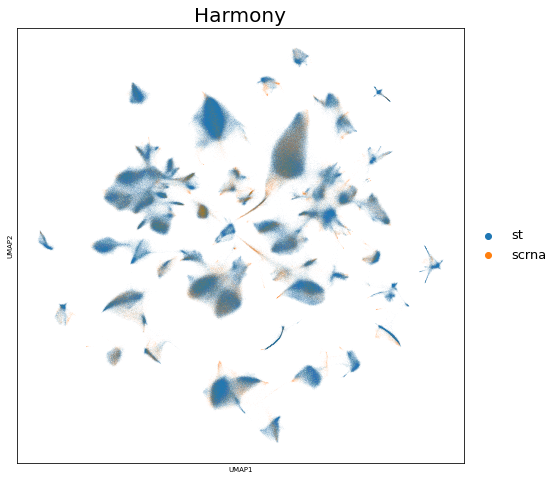

In [39]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(8,8))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
ax=sc.pl.umap(combine_adata, color='dataset',legend_fontsize=13,ax=ax,show=False)
# sc.pl.umap(adata,size=4, color='sample',legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Harmony')
ax.title.set_fontsize(20)

leiden clustering

In [1]:
%%time
# Run louvain cluster
sc.tl.leiden(combine_adata, resolution = 1)


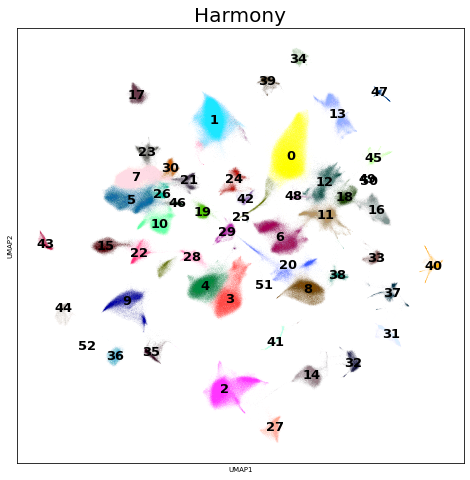

In [41]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(8,8))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
ax=sc.pl.umap(combine_adata, color='leiden',legend_loc='on data',legend_fontsize=13,ax=ax,show=False)
# sc.pl.umap(adata,size=4, color='sample',legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Harmony')
ax.title.set_fontsize(20)

In [42]:
sc.tl.rank_genes_groups(combine_adata, 'leiden', method='t-test')

In [44]:
combine_adata_st=combine_adata[combine_adata.obs['dataset']=='st',:]

analysis

In [46]:
clusterid_num=np.zeros((combine_adata.obs['leiden'].unique().shape[0],2))
clusterid_TaxonomyRank1=np.zeros((combine_adata.obs['leiden'].unique().shape[0],combine_adata.obs['TaxonomyRank1'].unique().shape[0]-1))
clusterid_TaxonomyRank2=np.zeros((combine_adata.obs['leiden'].unique().shape[0],combine_adata.obs['TaxonomyRank2'].unique().shape[0]-1))
clusterid_TaxonomyRank3=np.zeros((combine_adata.obs['leiden'].unique().shape[0],combine_adata.obs['TaxonomyRank3'].unique().shape[0]-1))
clusterid_TaxonomyRank4=np.zeros((combine_adata.obs['leiden'].unique().shape[0],combine_adata.obs['TaxonomyRank4'].unique().shape[0]-1))
clusterid_Description=np.zeros((combine_adata.obs['leiden'].unique().shape[0],combine_adata.obs['Description'].unique().shape[0]-1))

for ind,i in enumerate(combine_adata.obs['leiden'].unique()):
    pd_cluster_i=combine_adata.obs.loc[combine_adata.obs['leiden']==i,:]

    #num of st and scrna
    clusterid_num[ind,0]=pd.value_counts(pd_cluster_i['dataset'])['st']
    clusterid_num[ind,1]=pd.value_counts(pd_cluster_i['dataset'])['scrna']

    s=pd.value_counts(pd_cluster_i['TaxonomyRank1'])
    for indj, j in enumerate(combine_adata.obs['TaxonomyRank1'].cat.categories):
        clusterid_TaxonomyRank1[ind,indj]=s[j]
    
    s2=pd.value_counts(pd_cluster_i['TaxonomyRank2'])
    for indj, j in enumerate(combine_adata.obs['TaxonomyRank2'].cat.categories):
        clusterid_TaxonomyRank2[ind,indj]=s2[j]
        
    s3=pd.value_counts(pd_cluster_i['TaxonomyRank3'])
    for indj, j in enumerate(combine_adata.obs['TaxonomyRank3'].cat.categories):
        clusterid_TaxonomyRank3[ind,indj]=s3[j]
        
    s4=pd.value_counts(pd_cluster_i['TaxonomyRank4'])
    for indj, j in enumerate(combine_adata.obs['TaxonomyRank4'].cat.categories):
        clusterid_TaxonomyRank4[ind,indj]=s4[j]
        
    s5=pd.value_counts(pd_cluster_i['Description'])
    for indj, j in enumerate(combine_adata.obs['Description'].cat.categories):
        clusterid_Description[ind,indj]=s5[j]         

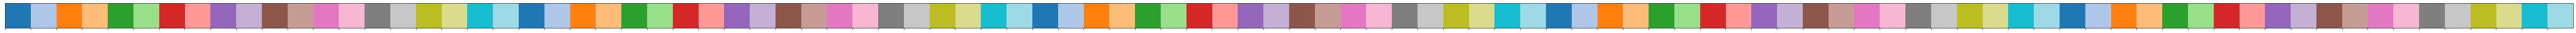

In [47]:
cluster_pl = sns.color_palette("tab20",100)
sns.palplot(cluster_pl)

In [48]:
level1='TaxonomyRank1'
level2='TaxonomyRank2'
level3='TaxonomyRank3'
level4='TaxonomyRank4'
level5='Description'
rank_taxo=[level1,level2,level3,level4,level5]

rank1

In [49]:
num_cluster=len(combine_adata.obs['leiden'].unique())

In [50]:
clusterid_TaxonomyRank1_per=clusterid_TaxonomyRank1.copy()
for i in range(num_cluster):
    clusterid_TaxonomyRank1_per[i]=clusterid_TaxonomyRank1[i]/sum(clusterid_TaxonomyRank1[i])

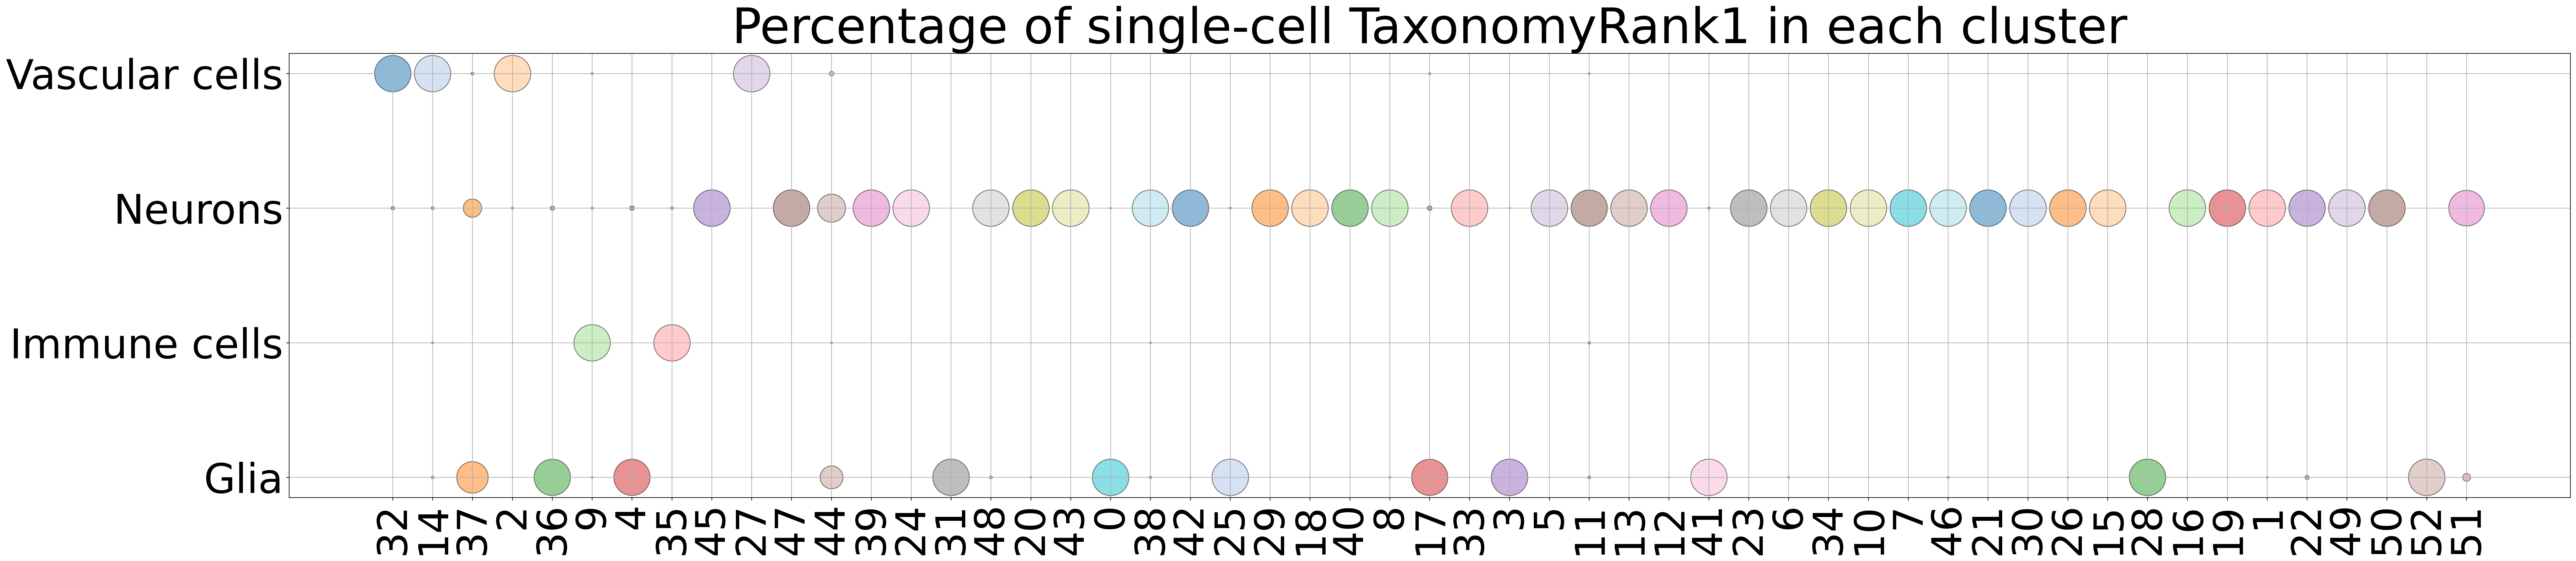

In [51]:
from itertools import product
plt.figure(figsize=(50,10),dpi=300)
# ax=fig.add_subplot(1,1,1)
plt.grid(True)
plt.xticks(np.arange(num_cluster), combine_adata.obs['leiden'].unique(),rotation=90,fontsize=50)  
plt.yticks(np.arange(4), combine_adata.obs['TaxonomyRank1'].cat.categories,fontsize=50)  
for i,j in product(range(num_cluster),range(4)):
    plt.scatter(i,j,s=clusterid_TaxonomyRank1_per[i,j]*2000,color=cluster_pl[i],alpha=0.5,edgecolor='k')
plt.title('Percentage of single-cell TaxonomyRank1 in each cluster',fontsize=60)
plt.show()

Text(0.5, 1.0, 'Rank1')

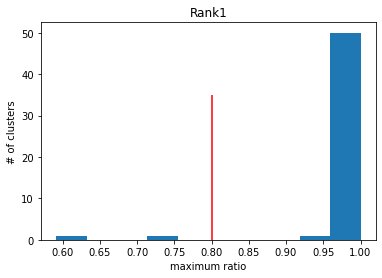

In [52]:
max_pct=np.amax(clusterid_TaxonomyRank1_per,axis=1)
maxlabel_in_rank1=combine_adata.obs['TaxonomyRank1'].cat.categories[np.argmax(clusterid_TaxonomyRank1_per,axis=1)]

plt.hist(max_pct)
combine_adata.obs['leiden'].unique()[np.where(max_pct<0.9)]
plt.vlines(0.8,0,35,colors='r')

plt.xlabel('maximum ratio')
plt.ylabel('# of clusters')
plt.title('Rank1')

rank2

In [53]:
clusterid_TaxonomyRank2_per=clusterid_TaxonomyRank2.copy()
for i in range(num_cluster):
    clusterid_TaxonomyRank2_per[i]=clusterid_TaxonomyRank2[i]/sum(clusterid_TaxonomyRank2[i])

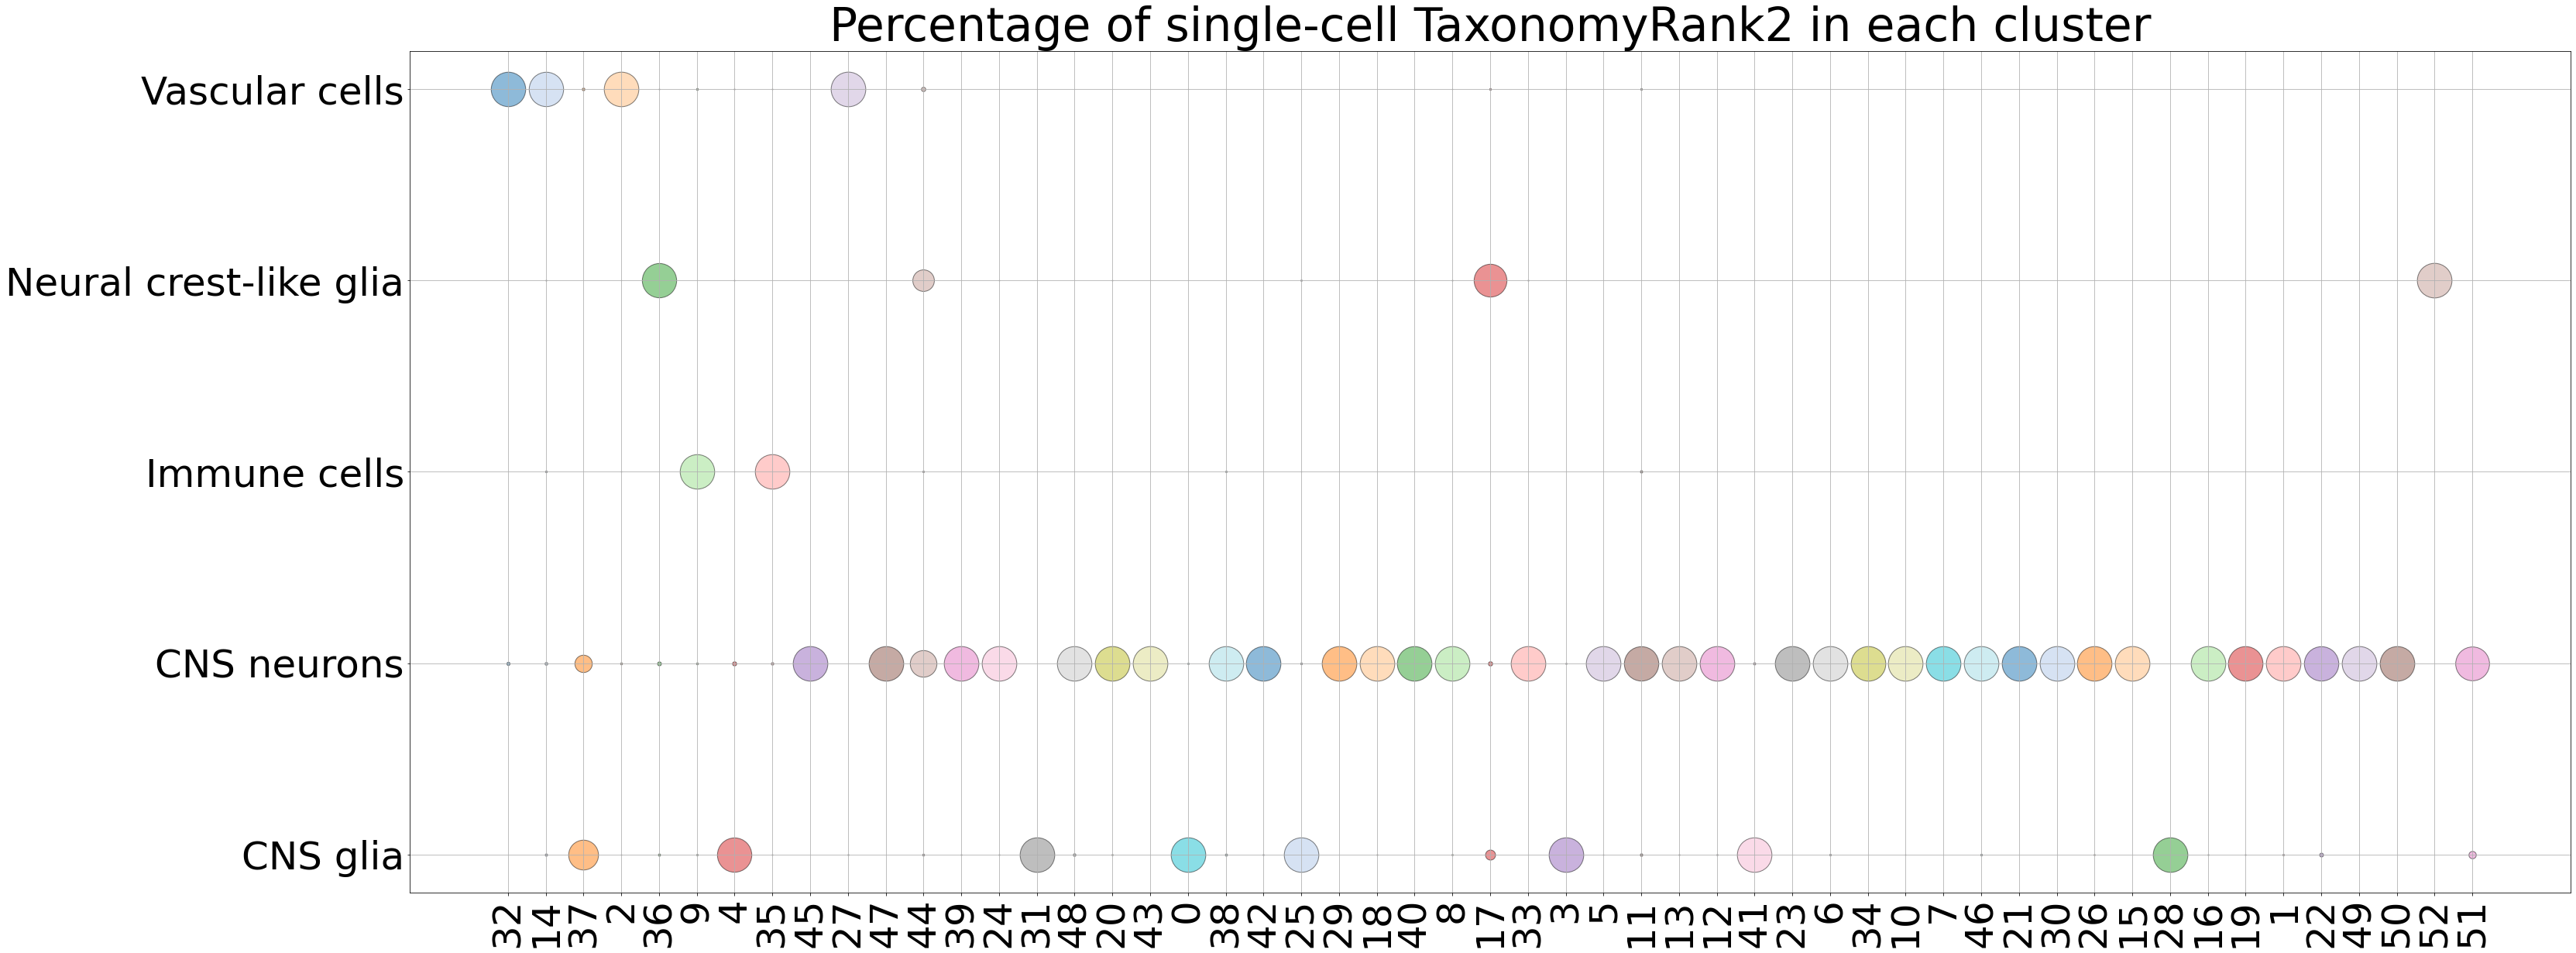

In [54]:
from itertools import product
plt.figure(figsize=(50,20))
# ax=fig.add_subplot(1,1,1)
plt.grid(True)
plt.xticks(np.arange(num_cluster), combine_adata.obs['leiden'].unique(),rotation=90,fontsize=50)  
plt.yticks(np.arange(5), combine_adata.obs['TaxonomyRank2'].cat.categories,fontsize=50)  
for i,j in product(range(num_cluster),range(5)):
    plt.scatter(i,j,s=clusterid_TaxonomyRank2_per[i,j]*2000,color=cluster_pl[i],alpha=0.5,edgecolor='k')
plt.title('Percentage of single-cell TaxonomyRank2 in each cluster',fontsize=60)
plt.show()

Text(0.5, 1.0, 'Rank2')

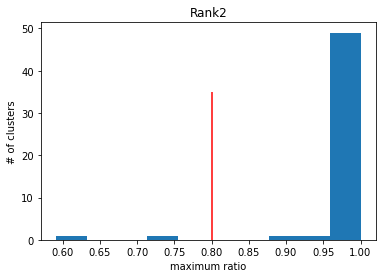

In [55]:
max_pct=np.amax(clusterid_TaxonomyRank2_per,axis=1)
maxlabel_in_rank1=combine_adata.obs['TaxonomyRank2'].cat.categories[np.argmax(clusterid_TaxonomyRank2_per,axis=1)]

plt.hist(max_pct)
combine_adata.obs['leiden'].unique()[np.where(max_pct<0.9)]
plt.vlines(0.8,0,35,colors='r')

plt.xlabel('maximum ratio')
plt.ylabel('# of clusters')
plt.title('Rank2')

rank3

In [56]:
clusterid_TaxonomyRank3_per=clusterid_TaxonomyRank3.copy()
for i in range(num_cluster):
    clusterid_TaxonomyRank3_per[i]=clusterid_TaxonomyRank3[i]/sum(clusterid_TaxonomyRank3[i])

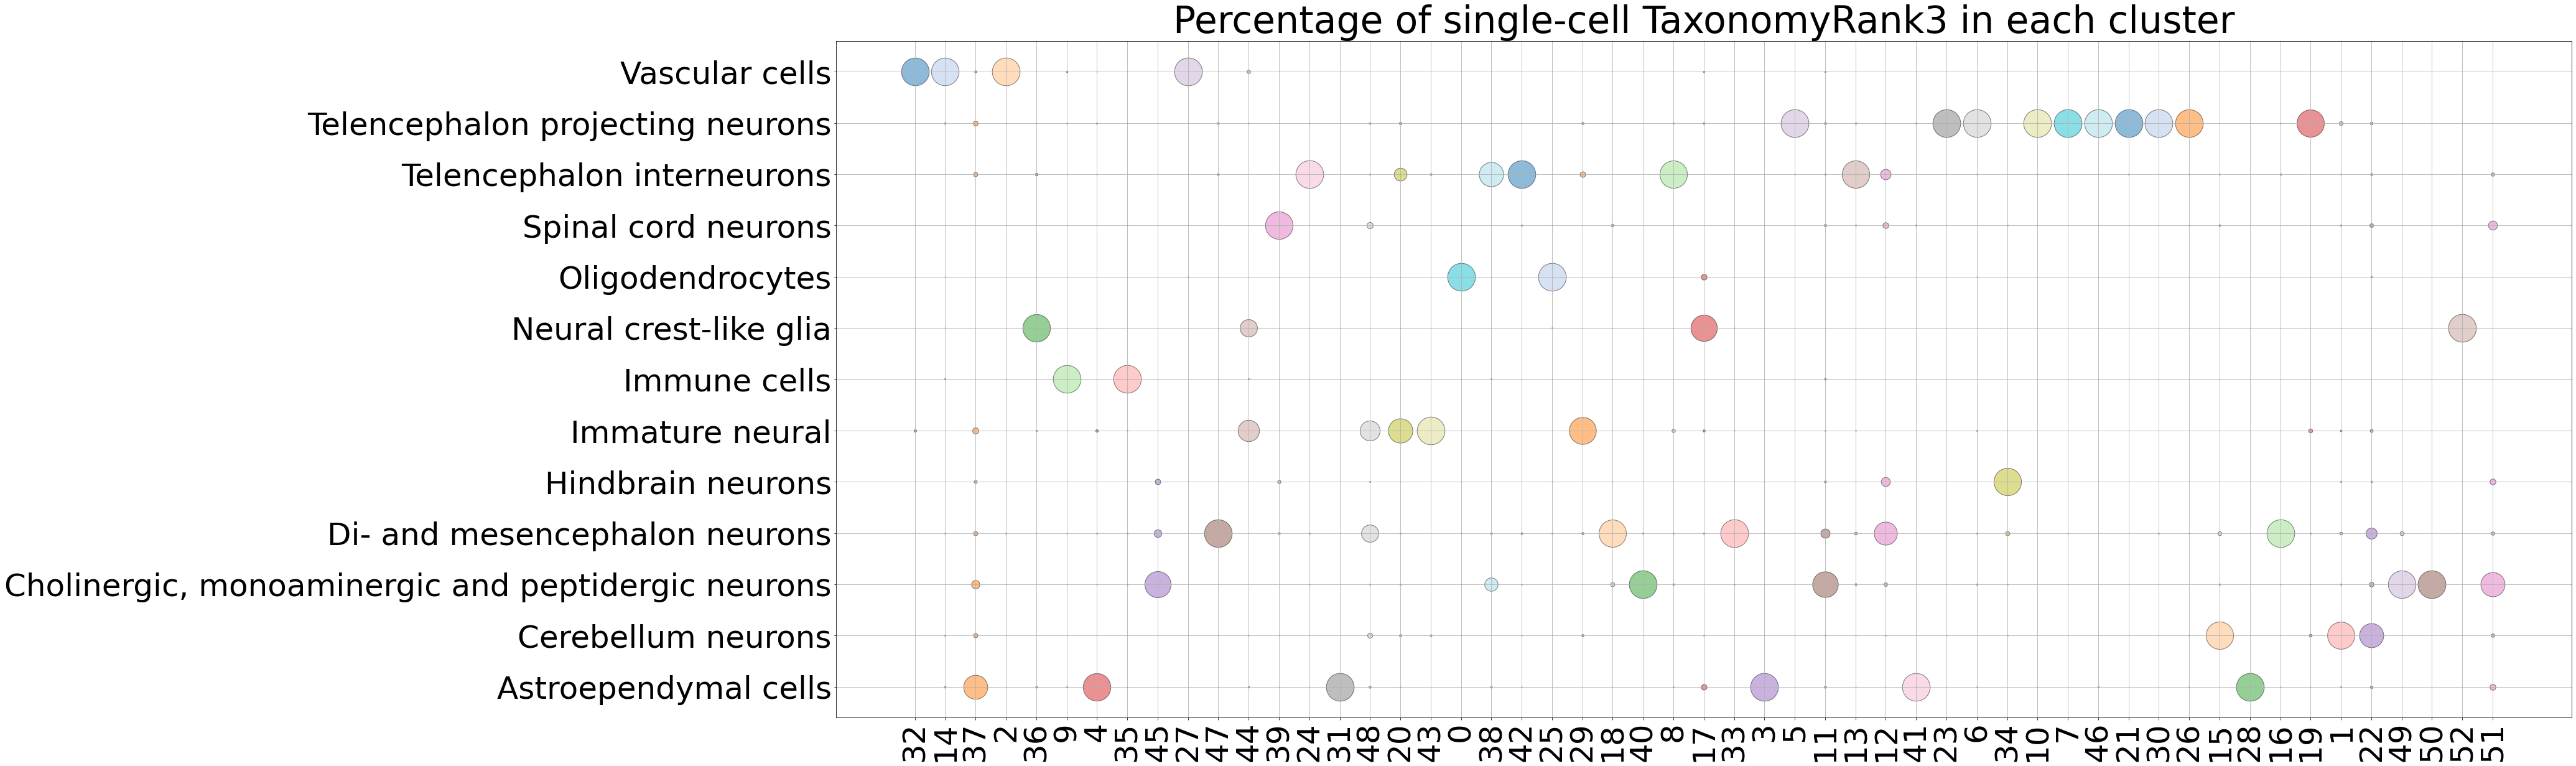

In [57]:
from itertools import product
plt.figure(figsize=(50,20))
# ax=fig.add_subplot(1,1,1)
plt.grid(True)
plt.xticks(np.arange(num_cluster), combine_adata.obs['leiden'].unique(),rotation=90,fontsize=50)  
plt.yticks(np.arange(13), combine_adata.obs['TaxonomyRank3'].cat.categories,fontsize=50)  
for i,j in product(range(num_cluster),range(13)):
    plt.scatter(i,j,s=clusterid_TaxonomyRank3_per[i,j]*2000,color=cluster_pl[i],alpha=0.5,edgecolor='k')
plt.title('Percentage of single-cell TaxonomyRank3 in each cluster',fontsize=60)
plt.show()

Text(0.5, 1.0, 'Rank3')

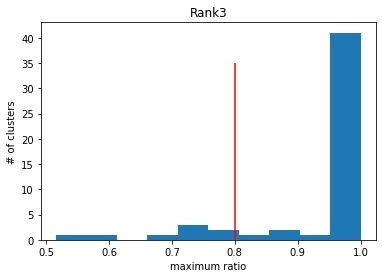

In [58]:
max_pct=np.amax(clusterid_TaxonomyRank3_per,axis=1)
maxlabel_in_rank1=combine_adata.obs['TaxonomyRank3'].cat.categories[np.argmax(clusterid_TaxonomyRank3_per,axis=1)]

plt.hist(max_pct)
combine_adata.obs['leiden'].unique()[np.where(max_pct<0.9)]
plt.vlines(0.8,0,35,colors='r')

plt.xlabel('maximum ratio')
plt.ylabel('# of clusters')
plt.title('Rank3')

rank4

In [59]:
clusterid_TaxonomyRank4_per=clusterid_TaxonomyRank4.copy()
for i in range(num_cluster):
    clusterid_TaxonomyRank4_per[i]=clusterid_TaxonomyRank4[i]/sum(clusterid_TaxonomyRank4[i])

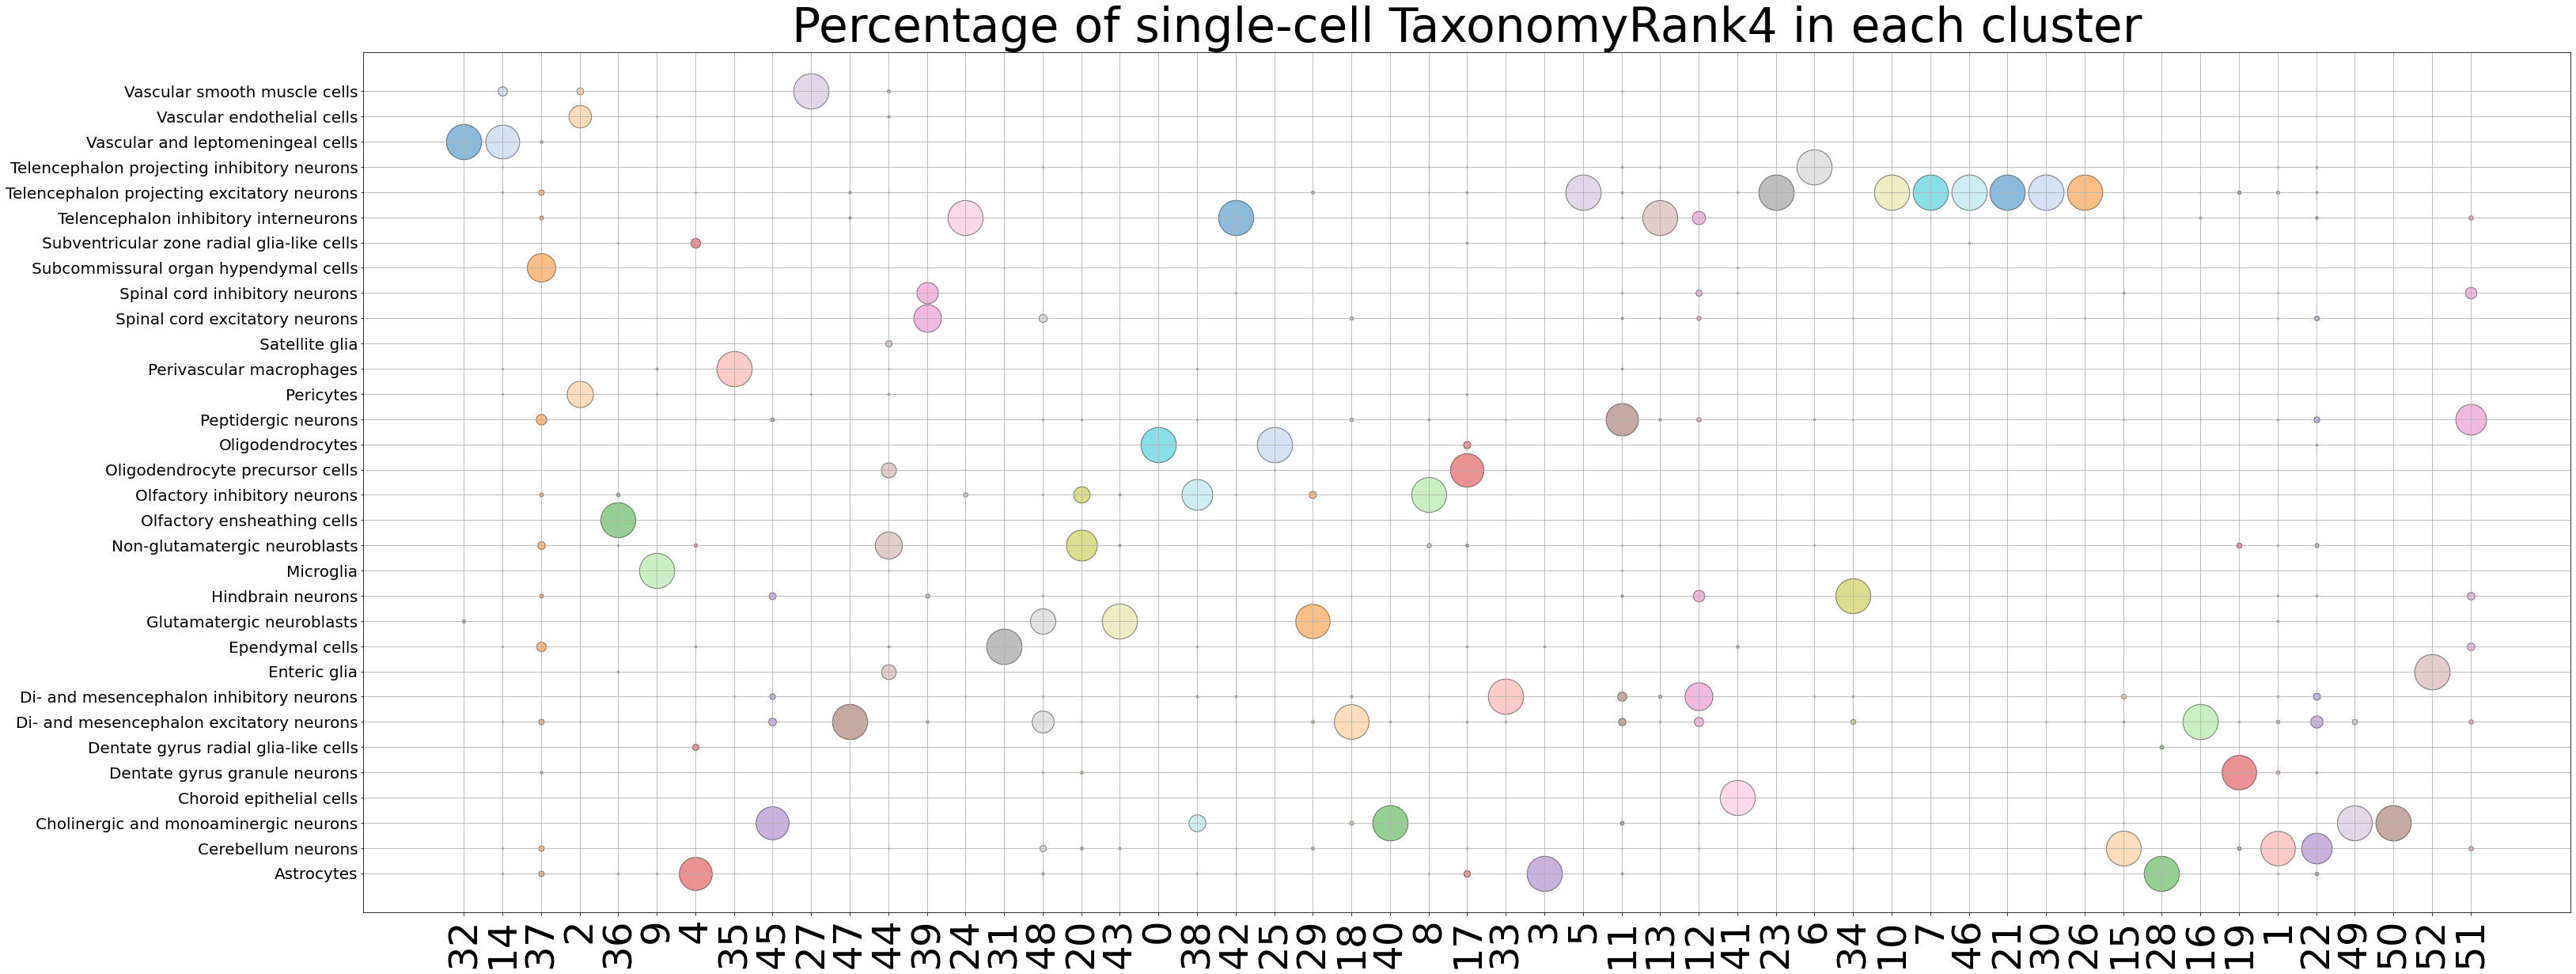

In [60]:
from itertools import product
plt.figure(figsize=(50,20))
# ax=fig.add_subplot(1,1,1)
plt.grid(True)
plt.xticks(np.arange(num_cluster), combine_adata.obs['leiden'].unique(),rotation=90,fontsize=50)  
plt.yticks(np.arange(32), combine_adata.obs['TaxonomyRank4'].cat.categories,fontsize=20)  
for i,j in product(range(num_cluster),range(32)):
    plt.scatter(i,j,s=clusterid_TaxonomyRank4_per[i,j]*2000,color=cluster_pl[i],alpha=0.5,edgecolor='k')
plt.title('Percentage of single-cell TaxonomyRank4 in each cluster',fontsize=60)
plt.show()

Text(0.5, 1.0, 'Rank4')

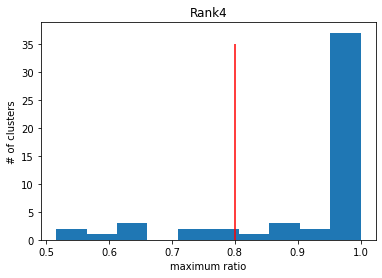

In [61]:
max_pct=np.amax(clusterid_TaxonomyRank4_per,axis=1)
maxlabel_in_rank1=combine_adata.obs['TaxonomyRank4'].cat.categories[np.argmax(clusterid_TaxonomyRank4_per,axis=1)]

plt.hist(max_pct)
combine_adata.obs['leiden'].unique()[np.where(max_pct<0.8)]
plt.vlines(0.8,0,35,colors='r')
plt.xlabel('maximum ratio')
plt.ylabel('# of clusters')
plt.title('Rank4')

Name clusters

In [62]:
#assign labels in cluster_label
clusterid_TaxonomyRank_per=[clusterid_TaxonomyRank1_per,
                            clusterid_TaxonomyRank2_per,
                           clusterid_TaxonomyRank3_per,
                           clusterid_TaxonomyRank4_per]
cluster_label_each=[]

max_pct=[]
for i in clusterid_TaxonomyRank_per:
    max_pct.append(np.amax(i,axis=1))
# max_pct1=np.amax(clusterid_TaxonomyRank1_per,axis=1)
# max_pct2=np.amax(clusterid_TaxonomyRank2_per,axis=1)
# max_pct3=np.amax(clusterid_TaxonomyRank3_per,axis=1)
# max_pct4=np.amax(clusterid_TaxonomyRank4_per,axis=1)

for indi,i in enumerate(rank_taxo[:4]):
    cluster_label_each.append(combine_adata.obs[i].cat.categories
                              [np.argmax(clusterid_TaxonomyRank_per[indi],axis=1)][np.where(max_pct[indi]>=0.8)])

In [63]:
if 'Rank4_Defined' in combine_adata.obs.columns:
    combine_adata.obs=combine_adata.obs.drop('Rank1_Defined',axis=1)
    combine_adata.obs=combine_adata.obs.drop('Rank2_Defined',axis=1)
    combine_adata.obs=combine_adata.obs.drop('Rank3_Defined',axis=1)
    combine_adata.obs=combine_adata.obs.drop('Rank4_Defined',axis=1)
for j in range(4):
    true_clusterid_rank=combine_adata.obs['leiden'].unique()[np.where(max_pct[j]>=0.8)]
    for indi,i in enumerate(true_clusterid_rank):
        combine_adata.obs.loc[combine_adata.obs['leiden']==i,'Rank'+str(j+1)+'_Defined']=cluster_label_each[j][indi]

# for indi,i in enumerate(true_clusterid_rank1):
#     combine_adata.obs.loc[combine_adata.obs['leiden']==i,'Rank1_Defined']=cluster_label_each[0][indi]

# for indi,i in enumerate(true_clusterid_rank2):
#     combine_adata.obs.loc[combine_adata.obs['leiden']==i,'Rank2_Defined']=cluster_label_each[1][indi]

# for indi,i in enumerate(true_clusterid_rank3):
#     combine_adata.obs.loc[combine_adata.obs['leiden']==i,'Rank3_Defined']=cluster_label_each[2][indi]

# for indi,i in enumerate(true_clusterid_rank4):
#     combine_adata.obs.loc[combine_adata.obs['leiden']==i,'Rank4_Defined']=cluster_label_each[3][indi]

In [64]:
combine_adata_st=combine_adata[combine_adata.obs['dataset']=='st',:]

Trying to set attribute `.obs` of view, copying.
... storing 'Rank1_Defined' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Rank2_Defined' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Rank3_Defined' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Rank4_Defined' as categorical


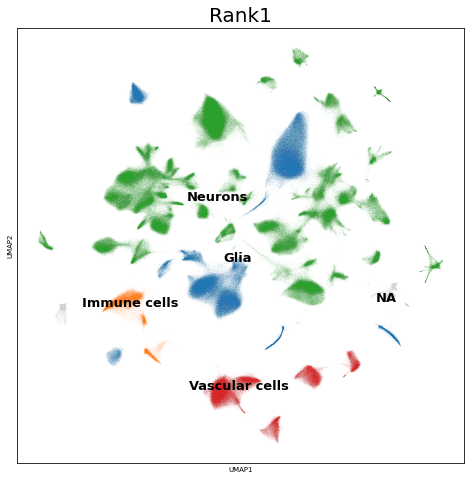

In [65]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(8,8))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
ax=sc.pl.umap(combine_adata_st, color='Rank1_Defined',legend_loc='on data',legend_fontsize=13,ax=ax,show=False)
# sc.pl.umap(adata,size=4, color='sample',legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Rank1')
ax.title.set_fontsize(20)

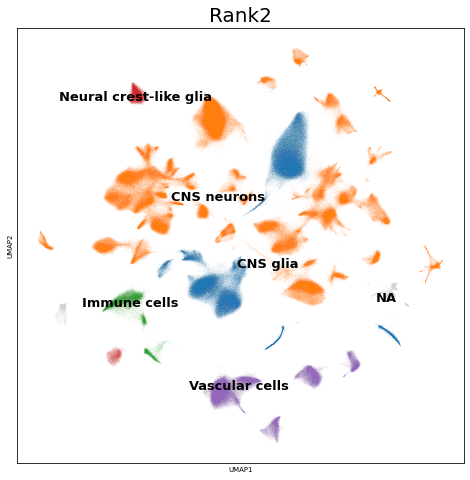

In [66]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(8,8))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
ax=sc.pl.umap(combine_adata_st, color='Rank2_Defined',legend_loc='on data',legend_fontsize=13,ax=ax,show=False)
# sc.pl.umap(adata,size=4, color='sample',legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Rank2')
ax.title.set_fontsize(20)

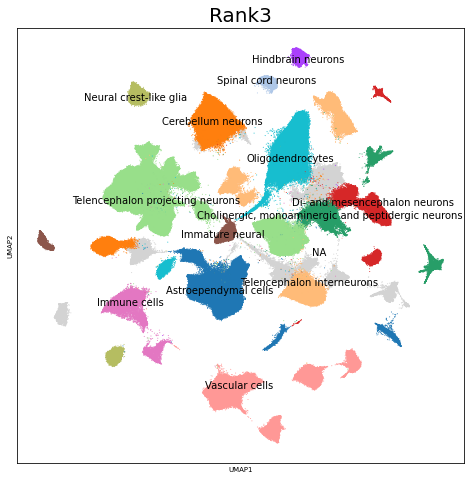

In [67]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(8,8))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
ax=sc.pl.umap(combine_adata_st,size=4, legend_loc='on data',legend_fontweight ='light',color='Rank3_Defined',legend_fontsize=10,ax=ax,show=False)
# sc.pl.umap(adata,size=4, color='sample',legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Rank3')
ax.title.set_fontsize(20)

In [68]:
cluster_pl=list(np.random.rand(42,3))

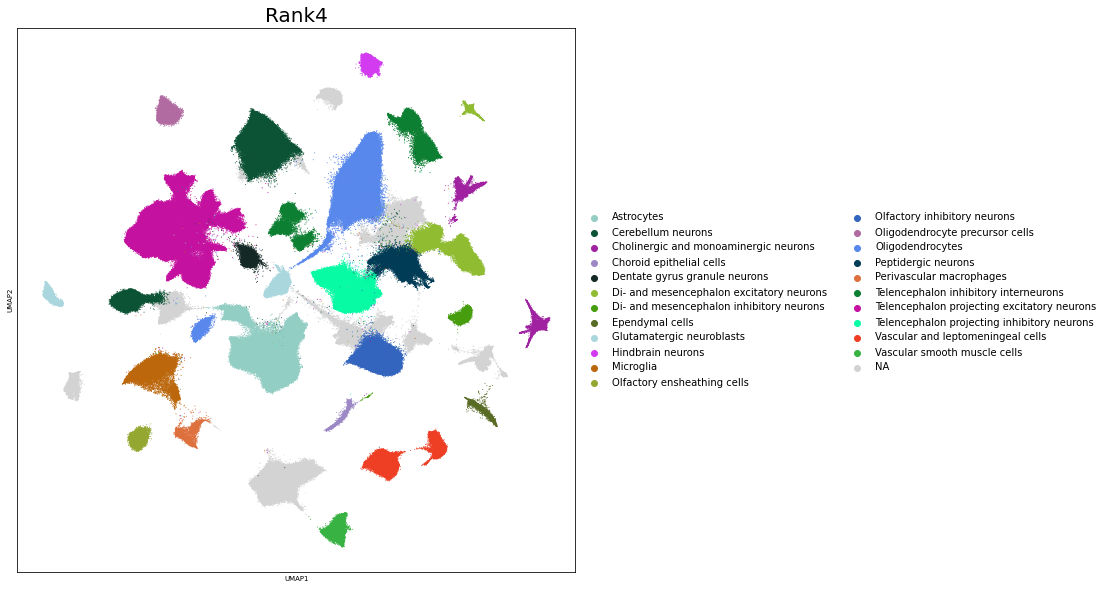

In [70]:
# combine_adata.obs['Rank4_Defined']=combine_adata.obs['Rank4_Defined'].astype('int')
# combine_adata.obs['Rank4_Defined']=combine_adata.obs['Rank4_Defined']
combine_adata.obs['Rank4_Defined']=combine_adata.obs['Rank4_Defined'].astype('category')
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 'large'})
fig,ax = plt.subplots(figsize=(10,10))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(7)
ax=sc.pl.umap(combine_adata_st,size=4, color='Rank4_Defined',#legend_loc='on data',
              legend_fontweight ='light',legend_fontsize=10,palette=cluster_pl,ax=ax,show=False)
# sc.pl.umap(adata,size=4, color='sample',legend_fontweight=100,legend_fontsize =20,ax=ax,show=False)
ax.set_title('Rank4')
ax.title.set_fontsize(20)

plot distribution of cells

In [76]:
cluster_pl=[(0.50073644, 0.98585307, 0.68441523), (0.07618405, 0.59789999, 0.27389582), (0.88541192, 0.91174287, 0.67716287), (0.49888577, 0.2692925 , 0.168824  ), (0.50254477, 0.81804417, 0.89023576), (0.22412601, 0.64535127, 0.89231617), (0.07367916, 0.79614377, 0.06814698), (0.11072297, 0.22896638, 0.50881243), (0.87621758, 0.66374928, 0.85861207), (0.13254612, 0.81012957, 0.46849738), (0.35931568, 0.46881892, 0.28105022), (0.78532594, 0.94309353, 0.74803515), (0.3838704 , 0.29606876, 0.89715318), (0.54601439, 0.37861424, 0.98458877), (0.76594675, 0.93241955, 0.18215191), (0.04290206, 0.30901371, 0.57713386), (0.27730869, 0.25665752, 0.547854  ), (0.6765545 , 0.22049784, 0.25719179), (0.53226053, 0.14554901, 0.07569058), (0.56905297, 0.04241662, 0.41548396), (0.94387832, 0.47618687, 0.88772186), (0.04457812, 0.67691415, 0.2396106 ), (0.10104427, 0.61935348, 0.75119081), (0.12501159, 0.15065496, 0.52871108), (0.7454498 , 0.2432429 , 0.75109417), (0.18617131, 0.68537728, 0.05271072), (0.20022221, 0.78253542, 0.41052029), (0.43128533, 0.34266265, 0.85824113), (0.64148718, 0.32461655, 0.81102081), (0.87785032, 0.2924339 , 0.27556315), (0.08707779, 0.26109255, 0.91194055), (0.69820949, 0.34686463, 0.74441555), (0.93271158, 0.45280799, 0.36666694), (0.91467761, 0.03304377, 0.40218128), (0.38473675, 0.56135467, 0.85068308), (0.49359172, 0.2697674 , 0.59780932), (0.19100293, 0.86178859, 0.56140191), (0.742361  , 0.01315983, 0.87002084), (0.851059  , 0.05113972, 0.67605016), (0.0473292 , 0.8025787 , 0.93314722)]


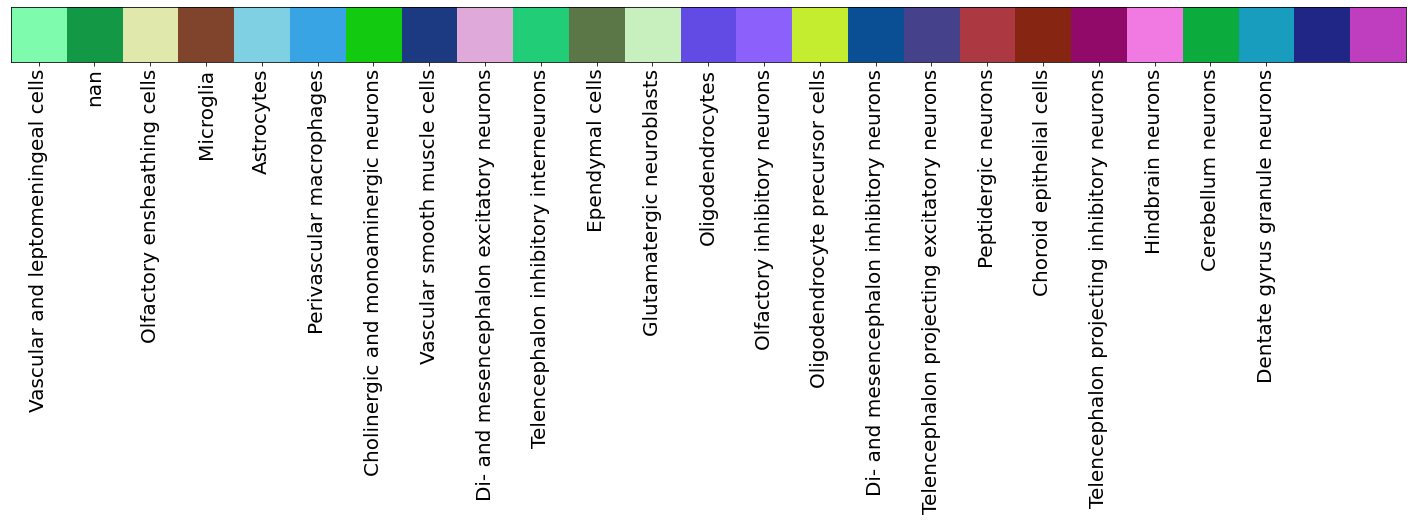

In [77]:
sns.palplot(cluster_pl[:25])
fig=plt.xticks(range(len(labeld)), labeld, size=20, rotation=90)
plt.show()

In [78]:
level1='Rank1_Defined'
level2='Rank2_Defined'
level3='Rank3_Defined'
level4='Rank4_Defined'

labela=list(pd_sc[level1].unique())
labelb=list(pd_sc[level2].unique())
labelc=list(pd_sc[level3].unique())
labeld=list(pd_sc[level4].unique())

labela=[x for x in labela if str(x)!='nan']
labelb=[x for x in labelb if str(x)!='nan']
labelc=[x for x in labelc if str(x)!='nan']
labeld=[x for x in labeld if str(x)!='nan']

In [79]:
batch_type=np.zeros(([len(pd_sc['sample'].unique()),len(labeld)]))
sample_order=[0,7,1,6,4,5,15,12,10,14,3,16,2,13,11,8,9,17,18,19]
for ind,i in enumerate(sample_order):
    cell_type=pd_sc.loc[pd_sc['sample']==pd_sc['sample'].unique()[i],level4]
    for indj,j in enumerate(labeld):
        batch_type[ind,indj]=sum(cell_type==j)

In [80]:
batch_type_per=batch_type.copy()
for i in range(20):
    batch_type_per[i]=batch_type_per[i]/sum(batch_type_per[i])

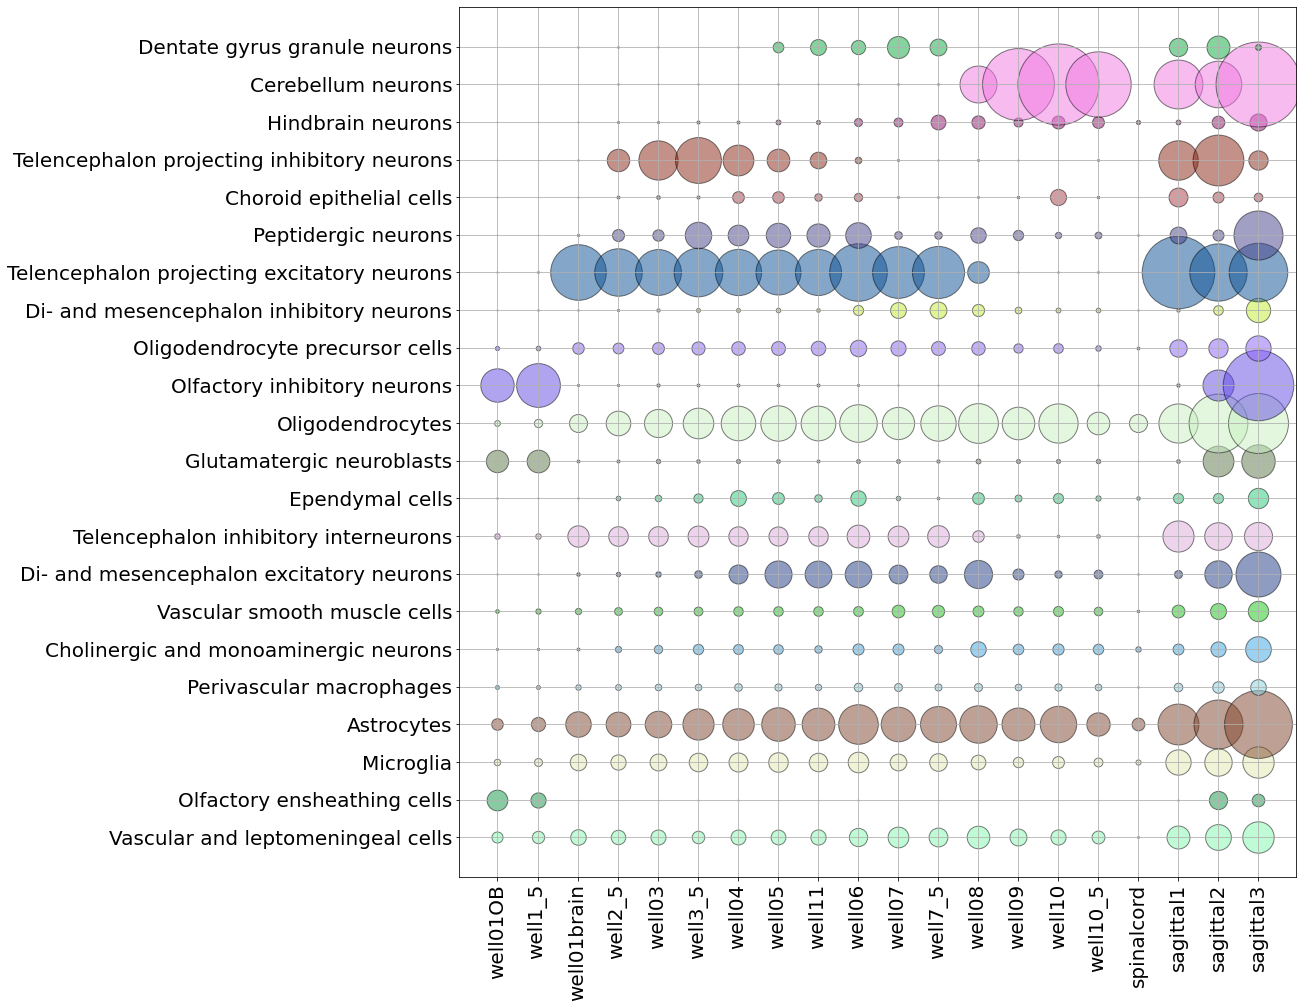

In [81]:
from itertools import product
plt.figure(figsize=(15,16))
# ax=fig.add_subplot(1,1,1)
plt.grid(True)
plt.xticks(np.arange(20), pd_sc['sample'].unique()[sample_order],rotation=90,fontsize=20)  
plt.yticks(np.arange(len(labeld)), labeld,fontsize=20)  
for i,j in product(range(20),range(len(labeld))):
    plt.scatter(i,j,s=batch_type[i,j]/5,color=cluster_pl[j],alpha=0.5,edgecolor='k')

plt.show()

In [82]:
combine_adata.write_h5ad('../output/adata_harmony_transfer.h5ad')

... storing 'Rank1_Defined' as categorical
... storing 'Rank2_Defined' as categorical
... storing 'Rank3_Defined' as categorical


subclustering of exci

# Save

In [ ]:
# adata.write_h5ad('output/adata_output.h5ad')

In [ ]:
# adata.obs.to_csv ('./new/obs_output.csv', index = True, header=True)